In [0]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

# Costa Rica Poverty Level Classiciation 

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


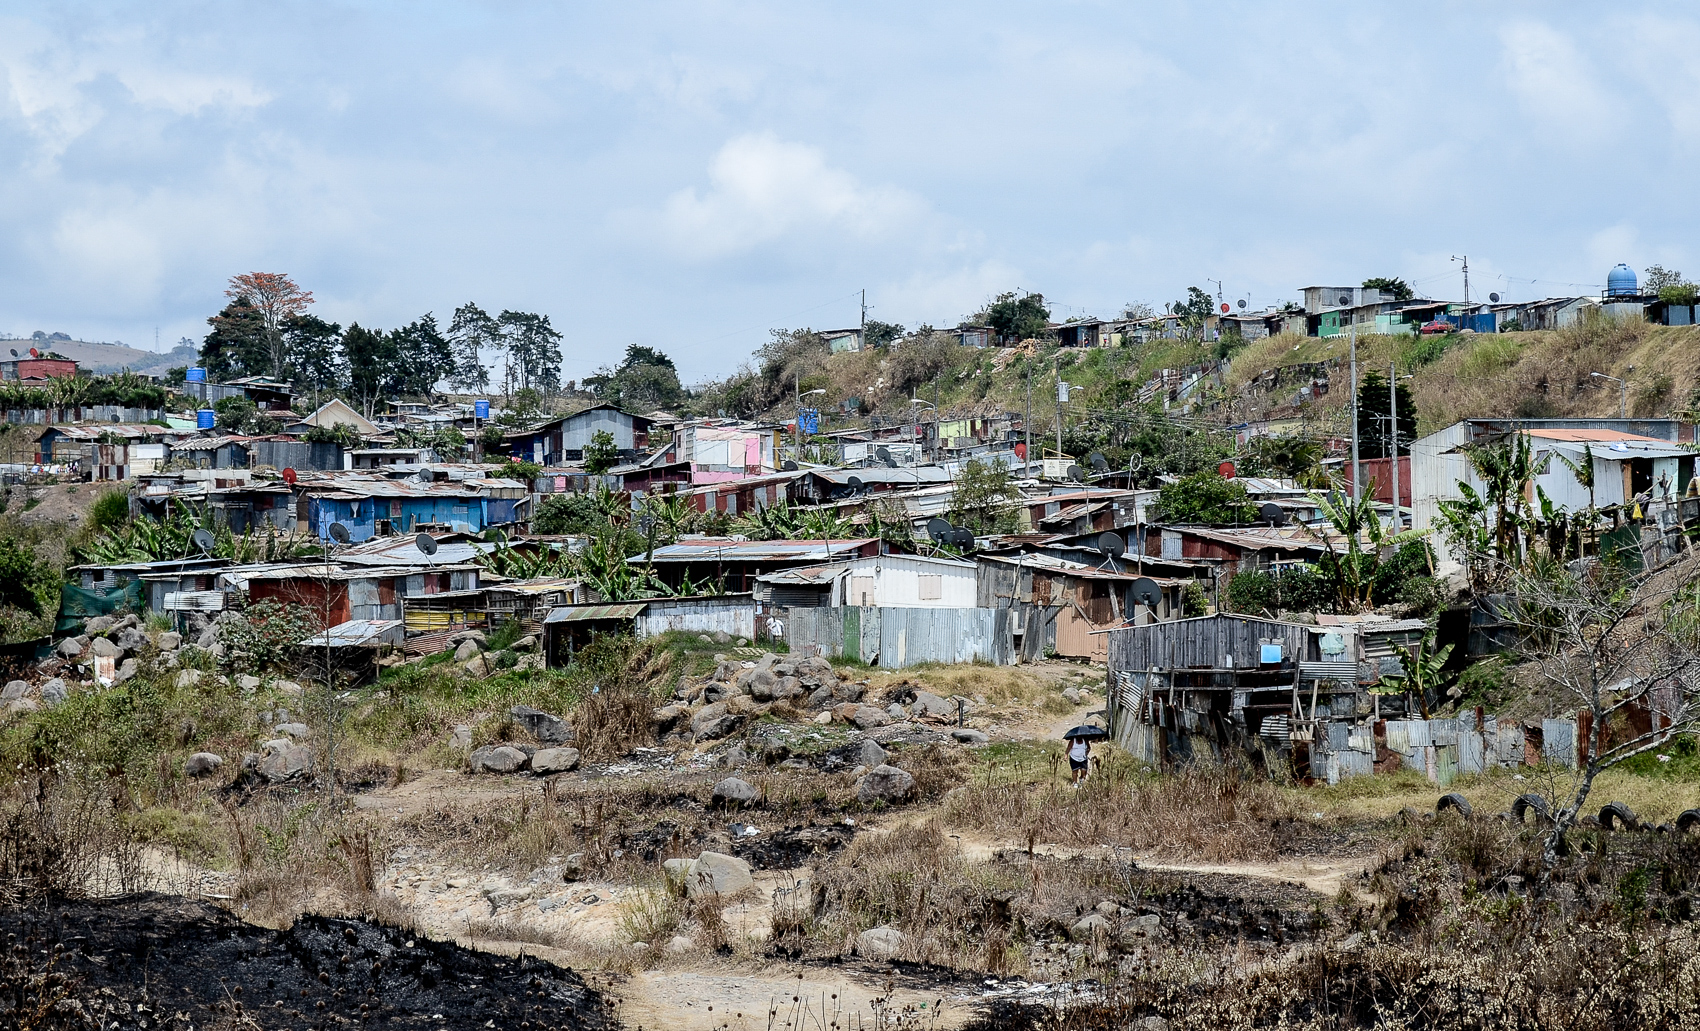

In [0]:
from google.colab import drive
drive.mount('/content/drive')

from IPython.display import Image
# Image(filename='Costa Rica.jpg')
Image(filename='/content/drive/My Drive/Data Science/Capstone II/Costa Rica.jpg')

# Understanding the Problem

- Identifying who needs aid



- Difficulty in helping the poorest due to lack of documentation

- Model that can identify need based on observable household attributes

- Two fold purpose (helping families in need and budget protection)

# Summary

The Inter-American Development Bank is asking the Kaggle community for help with income qualification for some of the world's poorest families. Are you up for the challenge?

Here's the backstory: Many social programs have a hard time making sure the right people are given enough aid. It’s especially tricky when a program focuses on the poorest segment of the population. The world’s poorest typically can’t provide the necessary income and expense records to prove that they qualify.

In Latin America, one popular method uses an algorithm to verify income qualification. It’s called the Proxy Means Test (or PMT). With PMT, agencies use a model that considers a family’s observable household attributes like the material of their walls and ceiling, or the assets found in the home to classify them and predict their level of need.

While this is an improvement, accuracy remains a problem as the region’s population grows and poverty declines.

To improve on PMT, the IDB (the largest source of development financing for Latin America and the Caribbean) has turned to the Kaggle community. They believe that new methods beyond traditional econometrics, based on a dataset of Costa Rican household characteristics, might help improve PMT’s performance.

Beyond Costa Rica, many countries face this same problem of inaccurately assessing social need. If Kagglers can generate an improvement, the new algorithm could be implemented in other countries around the world.

# Model Prep Work

## Imports and DataFrame Creation

In [0]:
pip install catboost

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(palette='Accent')

from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

from imblearn.over_sampling import SMOTE

from statsmodels.tools.tools import add_constant
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.feature_selection import SelectFromModel

from sklearn.metrics import confusion_matrix, classification_report, f1_score, balanced_accuracy_score, roc_curve, precision_recall_curve, roc_auc_score, auc

from sklearn.model_selection import cross_val_score, RandomizedSearchCV, train_test_split, GridSearchCV
from sklearn.preprocessing import label_binarize

import warnings
warnings.filterwarnings('ignore')

import timeit
from datetime import datetime

import itertools
from itertools import cycle

In [0]:
df = pd.read_csv('/content/drive/My Drive/Data Science/Capstone II/train 2.csv')
#https://www.kaggle.com/c/costa-rican-household-poverty-prediction

# Understanding Target Feature

Target - the target is an ordinal variable indicating groups of income levels.
- 1 = extreme poverty
- 2 = moderate poverty
- 3 = vulnerable households
- 4 = non vulnerable households

### Poverty Level Distribution

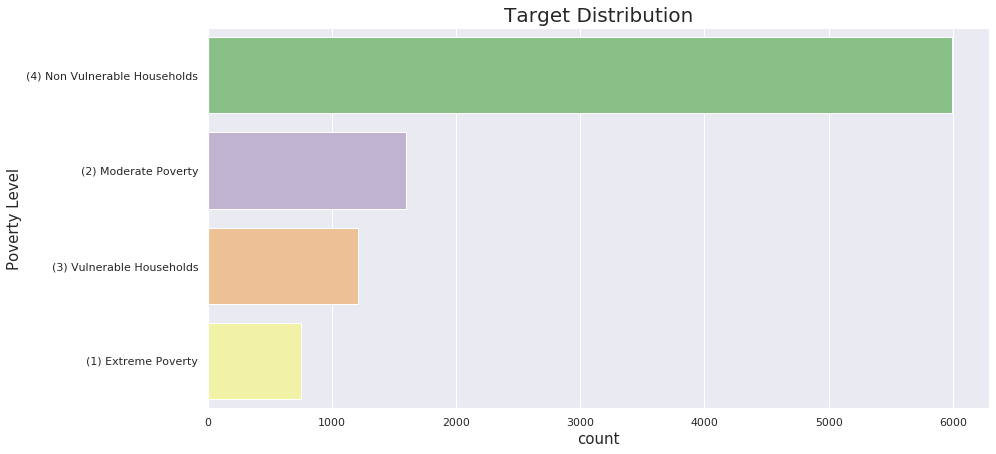

In [75]:
def poverty_level_names(row):
    if row == 1:
        return '(1) Extreme Poverty'
    elif row == 2:
        return '(2) Moderate Poverty'
    elif row == 3:
        return '(3) Vulnerable Households'
    else:
        return '(4) Non Vulnerable Households'

sns.set(palette='Accent')
plt.figure(figsize = (14,7))
ax = sns.countplot( y=df['Target'].apply(poverty_level_names))
ax = plt.title('Target Distribution', fontsize = 20)
plt.ylabel('Poverty Level', fontsize = 15)
plt.xlabel('count', fontsize = 15)
plt.show()

Notice unbalanced data, which will be handled later on.

# Understanding Feature Meaning

- v2a1, Monthly rent payment
- hacdor, =1 Overcrowding by bedrooms
- rooms,  number of all rooms in the house
- hacapo, =1 Overcrowding by rooms
- v14a, =1 has bathroom in the household
- refrig, =1 if the household has refrigerator
- v18q, owns a tablet
- v18q1, number of tablets household owns
- r4h1, Males younger than 12 years of age
- r4h2, Males 12 years of age and older
- r4h3, Total males in the household
- r4m1, Females younger than 12 years of age
- r4m2, Females 12 years of age and older
- r4m3, Total females in the household
- r4t1, persons younger than 12 years of age
- r4t2, persons 12 years of age and older
- r4t3, Total persons in the household
- tamhog, size of the household
- tamviv, number of persons living in the household
- escolari, years of schooling
- rez_esc, Years behind in school
- hhsize, household size
- paredblolad, =1 if predominant material on the outside wall is block or brick
- paredzocalo, "=1 if predominant material on the outside wall is socket (wood,  zinc or absbesto"
- paredpreb, =1 if predominant material on the outside wall is prefabricated or cement
- pareddes, =1 if predominant material on the outside wall is waste material
- paredmad, =1 if predominant material on the outside wall is wood
- paredzinc, =1 if predominant material on the outside wall is zink
- paredfibras, =1 if predominant material on the outside wall is natural fibers
- paredother, =1 if predominant material on the outside wall is other
- pisomoscer, "=1 if predominant material on the floor is mosaic,  ceramic,  terrazo"
- pisocemento, =1 if predominant material on the floor is cement
- pisoother, =1 if predominant material on the floor is other
- pisonatur, =1 if predominant material on the floor is  natural material
- pisonotiene, =1 if no floor at the household
- pisomadera, =1 if predominant material on the floor is wood
- techozinc, =1 if predominant material on the roof is metal foil or zink
- techoentrepiso, "=1 if predominant material on the roof is fiber cement,  mezzanine "
- techocane, =1 if predominant material on the roof is natural fibers
- techootro, =1 if predominant material on the roof is other
- cielorazo, =1 if the house has ceiling
- abastaguadentro, =1 if water provision inside the dwelling
- abastaguafuera, =1 if water provision outside the dwelling
- abastaguano, =1 if no water provision
- public, "=1 electricity from CNFL,  ICE,  ESPH/JASEC"
- planpri, =1 electricity from private plant
- noelec, =1 no electricity in the dwelling
- coopele, =1 electricity from cooperative
- sanitario1, =1 no toilet in the dwelling
- sanitario2, =1 toilet connected to sewer or cesspool
- sanitario3, =1 toilet connected to  septic tank
- sanitario5, =1 toilet connected to black hole or letrine
- sanitario6, =1 toilet connected to other system
- energcocinar1, =1 no main source of energy used for cooking (no kitchen)
- energcocinar2, =1 main source of energy used for cooking electricity
- energcocinar3, =1 main source of energy used for cooking gas
- energcocinar4, =1 main source of energy used for cooking wood charcoal
- elimbasu1, =1 if rubbish disposal mainly by tanker truck
- elimbasu2, =1 if rubbish disposal mainly by botan hollow or buried
- elimbasu3, =1 if rubbish disposal mainly by burning
- elimbasu4, =1 if rubbish disposal mainly by throwing in an unoccupied space
- elimbasu5, "=1 if rubbish disposal mainly by throwing in river,  creek or sea"
- elimbasu6, =1 if rubbish disposal mainly other
- epared1, =1 if walls are bad
- epared2, =1 if walls are regular
- epared3, =1 if walls are good
- etecho1, =1 if roof are bad
- etecho2, =1 if roof are regular
- etecho3, =1 if roof are good
- eviv1, =1 if floor are bad
- eviv2, =1 if floor are regular
- eviv3, =1 if floor are good
- dis, =1 if disable person
- male, =1 if male
- female, =1 if female
- estadocivil1, =1 if less than 10 years old
- estadocivil2, =1 if free or coupled uunion
- estadocivil3, =1 if married
- estadocivil4, =1 if divorced
- estadocivil5, =1 if separated
- estadocivil6, =1 if widow/er
- estadocivil7, =1 if single
- parentesco1, =1 if household head
- parentesco2, =1 if spouse/partner
- parentesco3, =1 if son/doughter
- parentesco4, =1 if stepson/doughter
- parentesco5, =1 if son/doughter in law
- parentesco6, =1 if grandson/doughter
- parentesco7, =1 if mother/father
- parentesco8, =1 if father/mother in law
- parentesco9, =1 if brother/sister
- parentesco10, =1 if brother/sister in law
- parentesco11, =1 if other family member
- parentesco12, =1 if other non family member
- idhogar, Household level identifier
- hogar_nin, Number of children 0 to 19 in household
- hogar_adul, Number of adults in household
- hogar_mayor, # of individuals 65+ in the household
- hogar_total, # of total individuals in the household
- dependency, Dependency rate, calculated = (number of members of the household younger than 19 or older than 64)/(number of member of household between 19 and 64)
- edjefe, years of education of male head of household, based on the interaction of escolari (years of education), head of household and gender, yes=1 and no=0
- edjefa, years of education of female head of household, based on the interaction of escolari (years of education), head of household and gender, yes=1 and no=0
- meaneduc,average years of education for adults (18+)
- instlevel1, =1 no level of education
- instlevel2, =1 incomplete primary
- instlevel3, =1 complete primary
- instlevel4, =1 incomplete academic secondary level
- instlevel5, =1 complete academic secondary level
- instlevel6, =1 incomplete technical secondary level
- instlevel7, =1 complete technical secondary level
- instlevel8, =1 undergraduate and higher education
- instlevel9, =1 postgraduate higher education
- bedrooms, number of bedrooms
- overcrowding, # persons per room
- tipovivi1, =1 own and fully paid house
- tipovivi2, "=1 own,  paying in installments"
- tipovivi3, =1 rented
- tipovivi4, =1 precarious
- tipovivi5, "=1 other(assigned,  borrowed)"
- computer, =1 if the household has notebook or desktop computer
- television, =1 if the household has TV
- mobilephone, =1 if mobile phone
- qmobilephone, # of mobile phones
- lugar1, =1 region Central
- lugar2, =1 region Chorotega
- lugar3, =1 region PacÃƒÂ­fico central
- lugar4, =1 region Brunca
- lugar5, =1 region Huetar AtlÃƒÂ¡ntica
- lugar6, =1 region Huetar Norte
- area1, =1 zona urbana
- area2, =2 zona rural
- age, Age in years
- SQBescolari, escolari squared
- SQBage, age squared
- SQBhogar_total, hogar_total squared
- SQBedjefe, edjefe squared
- SQBhogar_nin, hogar_nin squared
- SQBovercrowding, overcrowding squared
- SQBdependency, dependency squared
- SQBmeaned, square of the mean years of education of adults (>=18) in the household
- agesq, Age squared

#Feature Cleaning

## Reverse One Hot Encoding to Ordinal Features

In [0]:
# reverse one hot encode and label encode instead

# water = {0: none, 1: outside, 2: inside}
# wall = {0: bad, 1: fair, 2: good}
# roof = {0: bad, 1: fair, 2: good}
# floor = {0: bad, 1: fair, 2: good}
# education = 0: none, 9: masters
# home_ownership = {0: fully owned, 5: living with someone else}

water_df = df.loc[:,['abastaguano', 'abastaguafuera', 'abastaguadentro']]
wall_df = df.loc[:,['epared1', 'epared2', 'epared3']]
roof_df = df.loc[:,['etecho1', 'etecho2', 'etecho3']]
floor_df = df.loc[:,['eviv1', 'eviv2', 'eviv3']]
education_df = df.loc[:, ['instlevel1', 'instlevel2', 'instlevel3', 'instlevel4', 'instlevel5', 'instlevel6', 'instlevel7', 'instlevel8', 'instlevel9']]
home_ownership_df = df.loc[:, ['tipovivi1', 'tipovivi2', 'tipovivi3', 'tipovivi4', 'tipovivi5']]

In [0]:
for column in education_df:
    education_df[column].replace(1, education_df.columns.get_loc(column), inplace = True)
    
df['education'] = education_df.sum(axis = 1) 

for column in water_df:
    water_df[column].replace(1, water_df.columns.get_loc(column), inplace = True)
    
df['water'] = water_df.sum(axis = 1) 

for column in wall_df:
    wall_df[column].replace(1, wall_df.columns.get_loc(column), inplace = True)
    
df['wall'] = wall_df.sum(axis = 1) 

for column in roof_df:
    roof_df[column].replace(1, roof_df.columns.get_loc(column), inplace = True)
    
df['roof'] = roof_df.sum(axis = 1) 

for column in floor_df:
    floor_df[column].replace(1, floor_df.columns.get_loc(column), inplace = True)
    
df['floor'] = floor_df.sum(axis = 1) 

for column in home_ownership_df:
    home_ownership_df[column].replace(1, home_ownership_df.columns.get_loc(column), inplace = True)
    
df['home_ownership'] = home_ownership_df.sum(axis = 1) 


In [0]:
#drop columns that were combined from one hot encoding reversal and rename columns

df.drop(columns = ['abastaguano', 'abastaguafuera', 'abastaguadentro', 'epared1', 
                              'epared2', 'epared3', 'etecho1', 'etecho2', 'etecho3', 'eviv1', 
                              'eviv2', 'eviv3', 'instlevel1', 'instlevel2', 'instlevel3',
                              'instlevel4', 'instlevel5', 'instlevel6', 'instlevel7', 'instlevel8', 
                              'instlevel9', 'tipovivi1', 'tipovivi2', 'tipovivi3', 'tipovivi4', 
                              'tipovivi5'], 
                   inplace = True)

df.rename(columns={'hacapo':'Overcrowding_by_rooms',
                              'v14a': 'has_bathroom',
                              'v18q1': 'num_tablets',
                              'r4h2': 'male_over_12',
                              'r4h3': 'total_males',
                              'r4m2': 'females_over_12',
                              'r4m3': 'total_females',
                              'r4t2': 'total_over_12',
                              'r4t3': 'total_people',
                              'escolari': 'yrs_of_schooling',
                              'rez_esc' : 'yrs_behind_in_school',
                              'hhsize' : 'household_size',
                              'paredblolad': 'brick', 
                              'paredzocalo': 'socket',
                              'paredpreb': 'prefab'
                              }, 
                 inplace=True)


## Handle Object Dtypes

In [0]:
df.columns[df.dtypes==object]

Index(['Id', 'idhogar', 'dependency', 'edjefe', 'edjefa'], dtype='object')

#### Dependency

In [0]:
df['dependency'].unique()

array(['no', '8', 'yes', '3', '.5', '.25', '2', '.66666669', '.33333334',
       '1.5', '.40000001', '.75', '1.25', '.2', '2.5', '1.2', '4',
       '1.3333334', '2.25', '.22222222', '5', '.83333331', '.80000001',
       '6', '3.5', '1.6666666', '.2857143', '1.75', '.71428573',
       '.16666667', '.60000002'], dtype=object)

In [0]:
df['dependency'].replace('yes', 1, inplace = True)
df['dependency'].replace('no', 0, inplace = True)
df['dependency'] = df['dependency'].astype('float64')

#### Years of Education for Male and Female Head of Household edjefe / edjefa

In [0]:
df['edjefe'].unique()

array(['10', '12', 'no', '11', '9', '15', '4', '6', '8', '17', '7', '16',
       '14', '5', '21', '2', '19', 'yes', '3', '18', '13', '20'],
      dtype=object)

In [0]:
df['edjefa'].unique()

array(['no', '11', '4', '10', '9', '15', '7', '14', '13', '8', '17', '6',
       '5', '3', '16', '19', 'yes', '21', '12', '2', '20', '18'],
      dtype=object)

In [0]:
df['edjefe'].replace('yes', 1, inplace = True)
df['edjefe'].replace('no', 0, inplace = True)
df['edjefe'] = df['edjefe'].astype('int64')

df['edjefa'].replace('yes', 1, inplace = True)
df['edjefa'].replace('no', 0, inplace = True)
df['edjefa'] = df['edjefa'].astype('int64')

## Handling Null Values

#### Initial Check For Nulls


In [0]:
df.isna().sum().sort_values(ascending = False)

yrs_behind_in_school    7928
num_tablets             7342
v2a1                    6860
meaneduc                   5
SQBmeaned                  5
                        ... 
hogar_nin                  0
hogar_adul                 0
hogar_mayor                0
hogar_total                0
Id                         0
Length: 123, dtype: int64

#### Rent 'v2a1'

In [0]:
print('Rent Value Counts: \n \n{}'.format(df['v2a1'].value_counts()))
print('\n--------------\n')
print('Rent Null Values: {}'.format(df['v2a1'].isnull().sum()))

Rent Value Counts: 
 
150000.0    233
100000.0    181
200000.0    159
120000.0    149
50000.0     118
           ... 
119813.0      1
268153.0      1
542013.0      1
118097.0      1
108000.0      1
Name: v2a1, Length: 157, dtype: int64

--------------

Rent Null Values: 6860


In [0]:
rent_home_ownership_df = df.loc[:, ['v2a1', 'tipovivi1', 'tipovivi2', 'tipovivi3', 'tipovivi4', 'tipovivi5']]
null_rent = rent_home_ownership_df.loc[rent_home_ownership_df['v2a1'].isnull()]
print('Null rent and fully owns home: \n \n{}'.format(null_rent.loc[null_rent['tipovivi1']==1]))
print('\n--------------\n')
print('Null rent and owns with a mortgage: \n \n{}'.format(null_rent.loc[null_rent['tipovivi2']==1]))
print('\n--------------\n')
print('Null rent and rents: \n \n{}'.format(null_rent.loc[null_rent['tipovivi3']==1]))
print('\n--------------\n')
print('Null rent and precarious: \n \n{}'.format(null_rent.loc[null_rent['tipovivi4']==1]))
print('\n--------------\n')
print('Null rent and other: \n \n{}'.format(null_rent.loc[null_rent['tipovivi5']==1]))


Null rent and fully owns home: 
 
Empty DataFrame
Columns: [v2a1, tipovivi1, tipovivi2, tipovivi3, tipovivi4, tipovivi5]
Index: []

--------------

Null rent and owns with a mortgage: 
 
Empty DataFrame
Columns: [v2a1, tipovivi1, tipovivi2, tipovivi3, tipovivi4, tipovivi5]
Index: []

--------------

Null rent and rents: 
 
Empty DataFrame
Columns: [v2a1, tipovivi1, tipovivi2, tipovivi3, tipovivi4, tipovivi5]
Index: []

--------------

Null rent and precarious: 
 
Empty DataFrame
Columns: [v2a1, tipovivi1, tipovivi2, tipovivi3, tipovivi4, tipovivi5]
Index: []

--------------

Null rent and other: 
 
Empty DataFrame
Columns: [v2a1, tipovivi1, tipovivi2, tipovivi3, tipovivi4, tipovivi5]
Index: []


All of the null values for rent are because they do not have a rent payment (because they own the house, or because they are living with someone else, or possibly homeless. Therefore, the null values will be filled in with zeros.

In [0]:
df['v2a1'].fillna(value = 0, inplace = True)

#### Years Behind in School

In [0]:
print('Years Behind in School Value Counts: \n \n{}'.format(df['yrs_behind_in_school'].value_counts()))
print('\n--------------\n')
print('Years Behind in School Null Values: {}'.format(df['yrs_behind_in_school'].isnull().sum()))

Years Behind in School Value Counts: 
 
0.0    1211
1.0     227
2.0      98
3.0      55
4.0      29
5.0       9
Name: yrs_behind_in_school, dtype: int64

--------------

Years Behind in School Null Values: 7928


In [0]:
years_behind_school_age_df = df.loc[df['yrs_behind_in_school'].isnull(), ['yrs_behind_in_school', 'age']]
years_list = years_behind_school_age_df['age'].unique()
years_list.sort()
years_list

array([ 0,  1,  2,  3,  4,  5,  6, 10, 18, 19, 20, 21, 22, 23, 24, 25, 26,
       27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43,
       44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60,
       61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77,
       78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94,
       95, 97])

In [0]:
age_10_yrs_behind = df.loc[df['age']==10, ['age', 'yrs_behind_in_school']]
age_10_yrs_behind.loc[age_10_yrs_behind['yrs_behind_in_school'].isnull()]

,age,yrs_behind_in_school
2514,10,NaN


Since all of the null values for years behind in school (except 1) fall on people before or after school ages--the nulls will be filled in with zeros. 

In [0]:
df['yrs_behind_in_school'].fillna(value = 0, inplace = True)

#### Household Tablets 'v18q1'

In [0]:
df['num_tablets'].value_counts()

1.0    1586
2.0     444
3.0     129
4.0      37
5.0      13
6.0       6
Name: num_tablets, dtype: int64

Since there are no zeros on the number of tablets owned, I will fill in the null values with zero since that's what they seem to indicate.


In [0]:
df['num_tablets'].fillna(0, inplace = True)

#### Drop the remaining nulls since there are only 5 rows with null values.

In [0]:
df.dropna(axis = 0, inplace = True)

# Data Cleaning Summary

- Reverse One Hot Encoding

- Translation to English

- Update Data Types

- Understanding Null Values (years behind in school, rent, tablet ownership)

# Device Ownership and Poverty Level

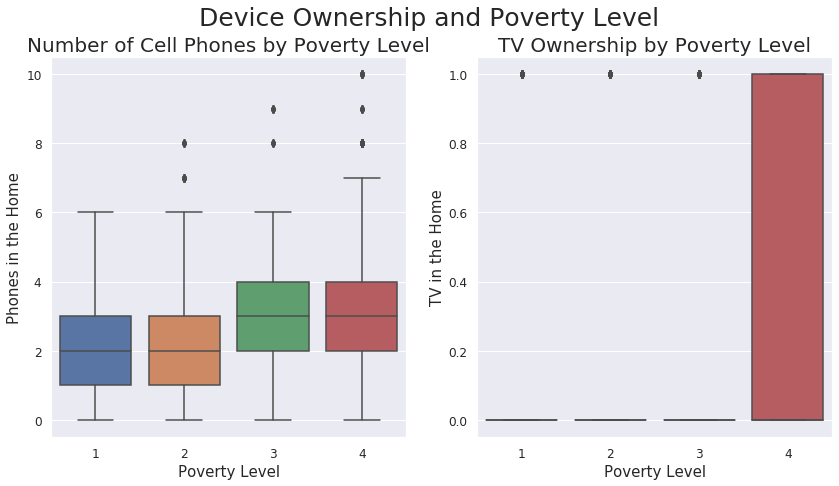

In [66]:
plt.figure(figsize = (14,7))

plt.subplot(1,2,1)
sns.boxplot(x = 'Target', y = 'qmobilephone', data = df)
plt.ylabel('Phones in the Home', fontsize = 15)
plt.xlabel('Poverty Level', fontsize = 15)
plt.title('Number of Cell Phones by Poverty Level', fontsize = 20)

plt.subplot(1,2,2)
sns.boxplot(x = 'Target', y = 'television', data = df)
plt.ylabel('TV in the Home', fontsize = 15)
plt.xlabel('Poverty Level', fontsize = 15)
plt.title('TV Ownership by Poverty Level', fontsize = 20)

plt.suptitle('Device Ownership and Poverty Level', fontsize = 25)
plt.show()

# Education and Poverty Level

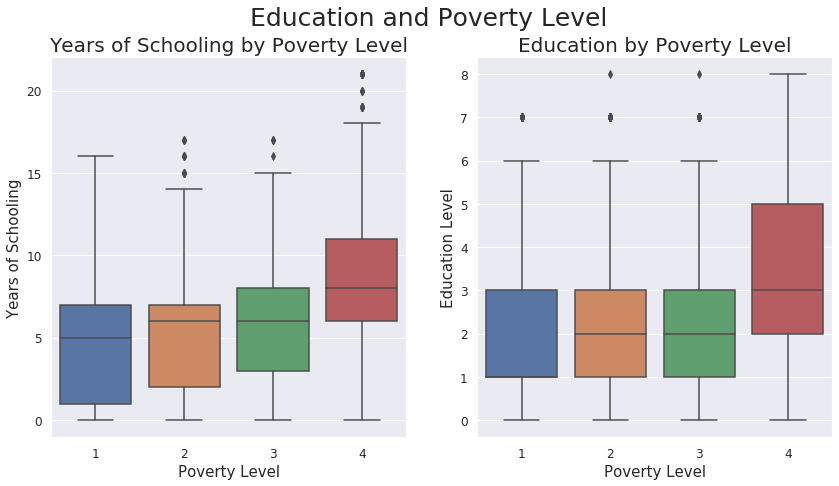

In [67]:
plt.figure(figsize=(14,7))

plt.subplot(1,2,1)
sns.boxplot(x = 'Target', y = 'yrs_of_schooling', data = df)
plt.ylabel('Years of Schooling', fontsize = 15)
plt.xlabel('Poverty Level', fontsize = 15)
plt.title('Years of Schooling by Poverty Level', fontsize = 20)

plt.subplot(1,2,2)
sns.boxplot(x = 'Target', y = 'education', data = df)
plt.ylabel('Education Level', fontsize = 15)
plt.xlabel('Poverty Level', fontsize = 15)
plt.title('Education by Poverty Level', fontsize = 20)

plt.suptitle('Education and Poverty Level', fontsize = 25)
plt.show()

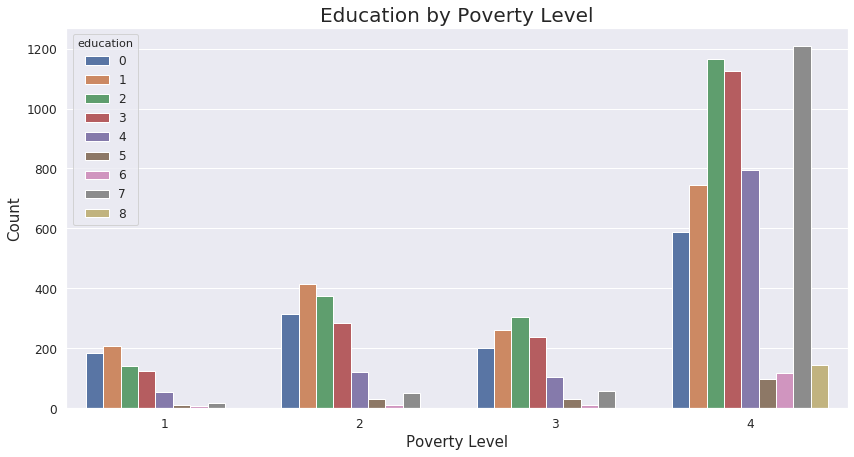

In [68]:
plt.figure(figsize = (14,7))
sns.countplot(x='Target', hue='education', data=df)
plt.xlabel('Poverty Level', fontsize = 15)
plt.ylabel('Count', fontsize = 15)
plt.title('Education by Poverty Level', fontsize = 20)
plt.show()

# Housing and Poverty Level

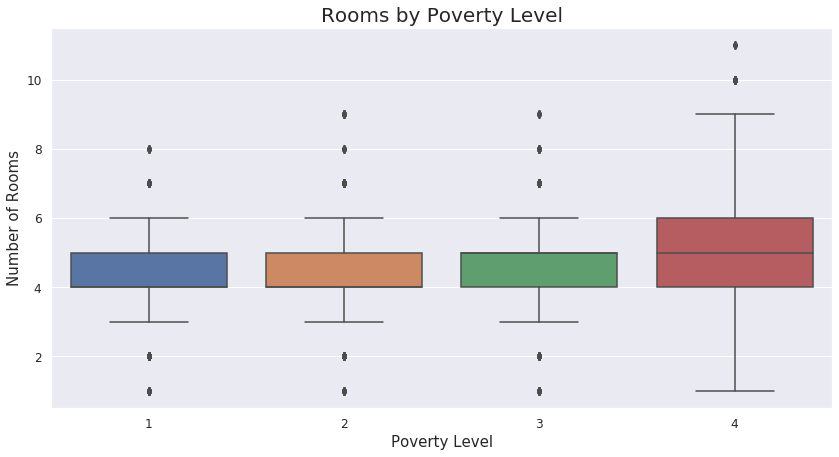

In [70]:
plt.figure(figsize = (14,7))
sns.boxplot(x = 'Target', y = 'rooms', data = df)
plt.ylabel('Number of Rooms', fontsize = 15)
plt.xlabel('Poverty Level', fontsize = 15)
plt.title('Rooms by Poverty Level', fontsize = 20)
plt.show()

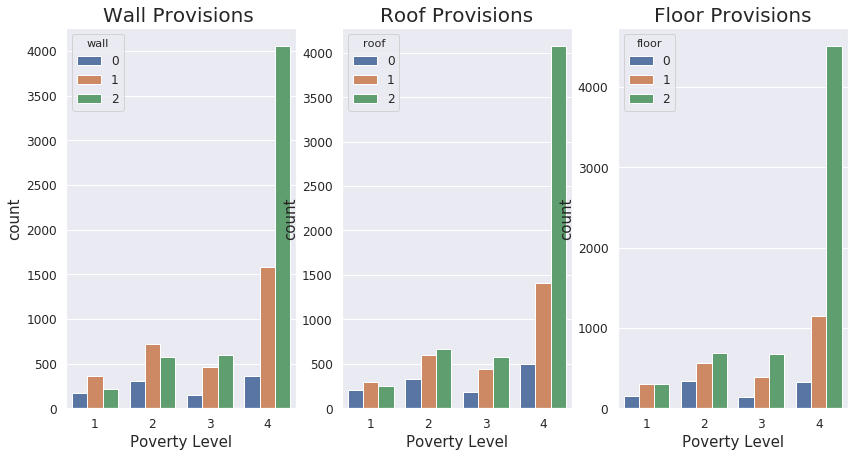

In [71]:
plt.figure(figsize = (14,7))

plt.subplot(1,3,1)
sns.countplot(x='Target', hue='wall', data=df)
plt.xlabel('Poverty Level', fontsize = 15)
plt.ylabel('count', fontsize = 15)
plt.title('Wall Provisions ', fontsize = 20)

plt.subplot(1,3,2)
sns.countplot(x='Target', hue='roof', data=df)
plt.xlabel('Poverty Level', fontsize = 15)
plt.ylabel('count', fontsize = 15)
plt.title('Roof Provisions', fontsize = 20)

plt.subplot(1,3,3)
sns.countplot(x='Target', hue='floor', data=df)
plt.xlabel('Poverty Level', fontsize = 15)
plt.ylabel('count', fontsize = 15)
plt.title('Floor Provisions', fontsize = 20)

plt.show()

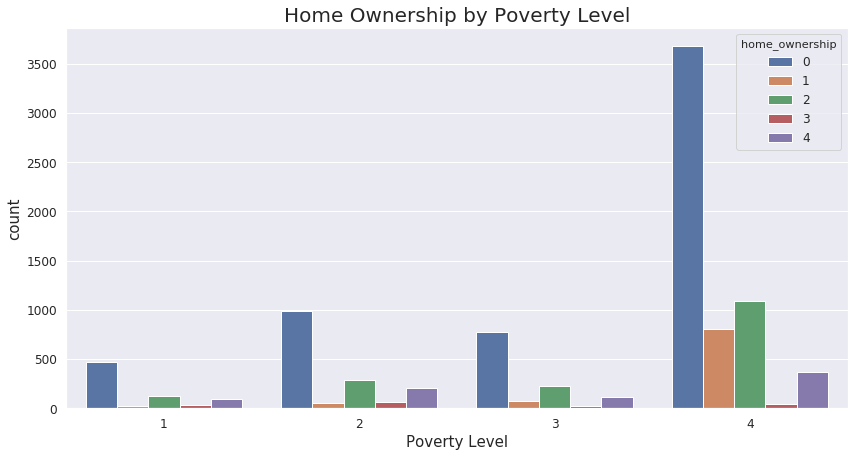

In [72]:
plt.figure(figsize = (14,7))

sns.countplot(x='Target', hue='home_ownership', data=df)
plt.xlabel('Poverty Level', fontsize = 15)
plt.ylabel('count', fontsize = 15)
plt.title('Home Ownership by Poverty Level', fontsize = 20)

plt.show()

It seems that regardless of poverty level, most Costa Ricans own their home outright (class 0). 

### Household and Poverty Level

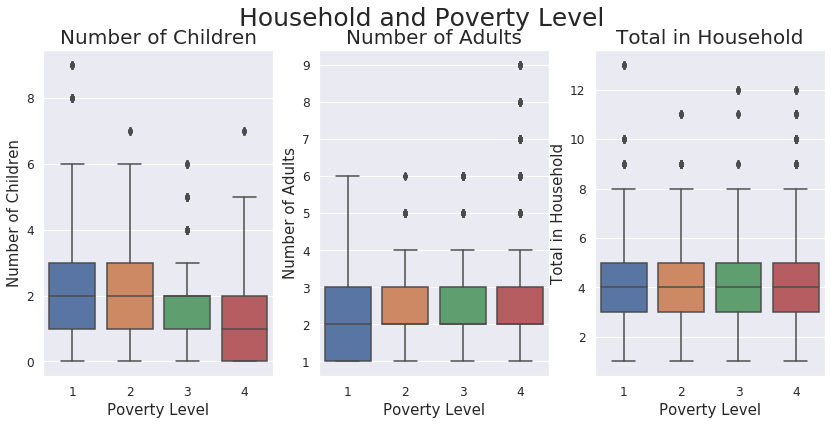

In [73]:
plt.figure(figsize=(14,6))

plt.subplot(1,3,1)
sns.boxplot(x = 'Target', y = 'hogar_nin', data = df)
plt.ylabel('Number of Children', fontsize = 15)
plt.xlabel('Poverty Level', fontsize = 15)
plt.title('Number of Children', fontsize = 20)

plt.subplot(1,3,2)
sns.boxplot(x = 'Target', y = 'hogar_adul', data = df)
plt.ylabel('Number of Adults', fontsize = 15)
plt.xlabel('Poverty Level', fontsize = 15)
plt.title('Number of Adults', fontsize = 20)

plt.subplot(1,3,3)
sns.boxplot(x = 'Target', y = 'hogar_total', data = df)
plt.ylabel('Total in Household', fontsize = 15)
plt.xlabel('Poverty Level', fontsize = 15)
plt.title('Total in Household', fontsize = 20)

plt.suptitle('Household and Poverty Level', fontsize = 25)
plt.show()

Basically, those in poverty have less adults, more kids than those not in poverty. 

## Initial Feature Selection

Drop features due to multicollinearity or low impact on model. Drop ID numbers. 

In [0]:
df1 = df.copy()
df1.drop(columns = ['v18q', 'edjefe', 'Id', 'idhogar', 'hacdor', 'hogar_total'],
                 inplace = True)

## Check for Multicollinearity 

In [0]:
abs(df1.corr()['Target']).sort_values(ascending = True)

planpri         0.000551
paredother      0.000615
coopele         0.002398
estadocivil6    0.003306
estadocivil7    0.004391
                  ...   
r4t1            0.316560
hogar_nin       0.328359
meaneduc        0.335203
Target          1.000000
elimbasu5            NaN
Name: Target, Length: 117, dtype: float64

# First Model Pass Through

## Random Forest


#### Baseline Random Forest

Duration: 0:00:00.315533


Train Accuracy: 0.9988496130516629
Test Accuracy: 0.9141810570381999
Test F1: 0.9141810570381999




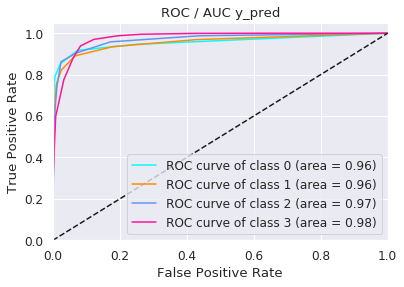

In [0]:
#Train test split
X = df1.drop(columns = ['Target']) 
y = df1['Target']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 21, test_size = .2)

#Balance data
sm = SMOTE(random_state=42, sampling_strategy= 'not majority')
X_train_array, y_train_array = sm.fit_resample(X_train, y_train)
y_train_resampled = pd.Series(y_train_array)
X_train_resampled = pd.DataFrame(X_train_array, columns = X_train.columns)

#run model
rfc = RandomForestClassifier(random_state = 21, n_jobs = -1) 

start_time = datetime.now()
rfc.fit(X_train_resampled, y_train_resampled)
end_time = datetime.now()
print('Duration: {}'.format(end_time - start_time))
print('\n')

#model results
y_pred = rfc.predict(X_test)
print('Train Accuracy: {}'.format(rfc.score(X_train_resampled, y_train_resampled)))
print('Test Accuracy: {}'.format(rfc.score(X_test, y_test)))
print('Test F1: {}'.format(f1_score(y_test, y_pred, average = 'weighted')))
print('\n')

#set up ROC/AUC
y_score = rfc.predict_proba(X_test)
n_classes = 4

y_test_bin = label_binarize(y_test, classes=[1, 2, 3, 4])

fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

#plot 
plt.figure()

colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'deeppink'])
for i, color in zip(range(0, 4, 1), colors):
    plt.plot(fpr[i], tpr[i], color=color,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC / AUC y_pred')
plt.legend(loc="lower right")
plt.show()

#### Classification Report

In [0]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           1       0.91      0.79      0.85       169
           2       0.88      0.81      0.84       292
           3       0.86      0.81      0.84       240
           4       0.93      0.98      0.95      1210

    accuracy                           0.91      1911
   macro avg       0.90      0.85      0.87      1911
weighted avg       0.91      0.91      0.91      1911



#### Confusion Matrix Function

In [0]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """

   

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.ylim(-.5,3.5)
    plt.show()

#### Confusion Matrix

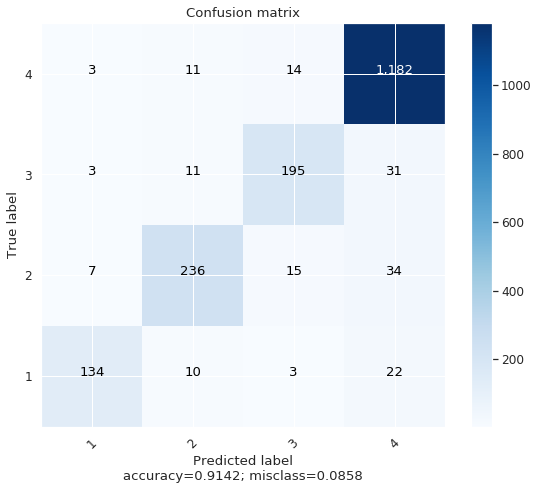

In [0]:
conf_matrix = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(conf_matrix, target_names = [1, 2, 3, 4], normalize=False)

#### Random Forest Hyperparameter Tuning GridSearch

In [0]:
#Train test split
X = df1.drop(columns = ['Target']) 
y = df1['Target']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 21, test_size = .2)

#Balance data
sm = SMOTE(random_state=42, sampling_strategy= 'not majority')
X_train_array, y_train_array = sm.fit_resample(X_train, y_train)
y_train_resampled = pd.Series(y_train_array)
X_train_resampled = pd.DataFrame(X_train_array, columns = X_train.columns)

#parameters
n_estimators = [1000]
max_features = ['auto'] #sqrt
max_depth = [80]
min_samples_split = [2]
min_samples_leaf = [1]
bootstrap = [True] # False]

# Create the random grid
params = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

#create model
grid = GridSearchCV(rfc, params, cv = 5)

#start timer
start_time = datetime.now()

#fit model
grid.fit(X_train_resampled, y_train_resampled)

#end timer
end_time = datetime.now()
print('Duration: {}'.format(end_time - start_time))

#create predictions
y_pred = grid.predict(X_test)

#metrics
print('Train Accuracy: {}'.format(grid.score(X_train_resampled, y_train_resampled)))
print('Test Accuracy: {}'.format(grid.score(X_test, y_test)))
print('Test F1: {}'.format(f1_score(y_test, y_pred, average = 'micro')))

#determine best parameters
grid.best_params_

Duration: 0:02:13.942943
Train Accuracy: 1.0
Test Accuracy: 0.9267399267399268
Test F1: 0.9267399267399268


{'bootstrap': True,
 'max_depth': 80,
 'max_features': 'auto',
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 1000}

#### Random Forest with Best Hyper Parameters

Duration: 0:01:29.591055
Train Accuracy: 1.0
Test Accuracy: 0.9434850863422292
Test F1: 0.9434850863422292


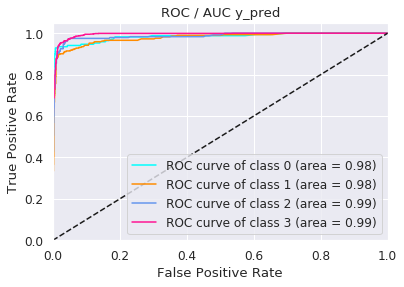

In [46]:
#Train test split
X = df1.drop(columns = ['Target']) 
y = df1['Target']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 21, test_size = .2)

#Balance data
sm = SMOTE(random_state=42, sampling_strategy= 'not majority')
X_train_array, y_train_array = sm.fit_resample(X_train, y_train)
y_train_resampled = pd.Series(y_train_array)
X_train_resampled = pd.DataFrame(X_train_array, columns = X_train.columns)

#create model
rfc = RandomForestClassifier(random_state = 21, n_estimators = 1000, max_depth = 80, min_samples_split=2, min_samples_leaf=1, bootstrap = False)

#start timer
start_time = datetime.now()

#fit model
rfc.fit(X_train_resampled, y_train_resampled)

#end timer
end_time = datetime.now()

#create predictions
y_pred = rfc.predict(X_test)

#metrics
print('Duration: {}'.format(end_time - start_time))
print('Train Accuracy: {}'.format(rfc.score(X_train, y_train)))
print('Test Accuracy: {}'.format(rfc.score(X_test, y_test)))
print('Test F1: {}'.format(f1_score(y_test, y_pred, average = 'weighted')))

#set up ROC/AUC
y_score = rfc.predict_proba(X_test)
n_classes = 4

y_test_bin = label_binarize(y_test, classes=[1, 2, 3, 4])

fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

#plot 
plt.figure()

colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'deeppink'])
for i, color in zip(range(0, 4, 1), colors):
    plt.plot(fpr[i], tpr[i], color=color,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC / AUC y_pred')
plt.legend(loc="lower right")
plt.show()

Hyperparameter tuning provided an improvement from .96, .96, .97, .98 AUC in the previous model

## Logistic Regression

Duration: 0:00:03.552572
Train Accuracy: 0.48789425467870695
Test Accuracy: 0.4924123495552067
Test F1: 0.4924123495552067


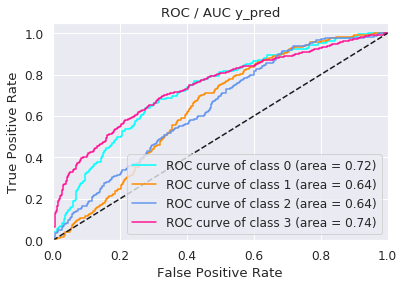

In [48]:
#Train test split
X = df1.drop(columns = ['Target']) 
y = df1['Target']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 21, test_size = .2)

#Balance data
sm = SMOTE(random_state=42, sampling_strategy= 'not majority')
X_train_array, y_train_array = sm.fit_resample(X_train, y_train)
y_train_resampled = pd.Series(y_train_array)
X_train_resampled = pd.DataFrame(X_train_array, columns = X_train.columns)

#create model
lrc = LogisticRegression(solver = 'lbfgs', multi_class = 'auto', max_iter = 200)

#start timer
start_time = datetime.now()

#fit model
lrc.fit(X_train_resampled, y_train_resampled)

#end timer
end_time = datetime.now()

#create predictions
y_pred = lrc.predict(X_test)

#metrics
print('Duration: {}'.format(end_time - start_time))
print('Train Accuracy: {}'.format(lrc.score(X_train, y_train)))
print('Test Accuracy: {}'.format(lrc.score(X_test, y_test)))
print('Test F1: {}'.format(f1_score(y_test, y_pred, average = 'weighted')))

#set up ROC/AUC
y_score = lrc.predict_proba(X_test)
n_classes = 4

y_test_bin = label_binarize(y_test, classes=[1, 2, 3, 4])

fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

#plot 
plt.figure()

colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'deeppink'])
for i, color in zip(range(0, 4, 1), colors):
    plt.plot(fpr[i], tpr[i], color=color,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC / AUC y_pred')
plt.legend(loc="lower right")
plt.show()

## KNN

Duration: 0:00:00.407919
Train Accuracy: 0.6927103782227457
Test Accuracy: 0.4416535845107274
Test F1: 0.4881921642154082
              precision    recall  f1-score   support

           1       0.21      0.39      0.28       169
           2       0.22      0.35      0.27       292
           3       0.19      0.35      0.25       240
           4       0.84      0.49      0.62      1210

    accuracy                           0.44      1911
   macro avg       0.37      0.39      0.35      1911
weighted avg       0.61      0.44      0.49      1911



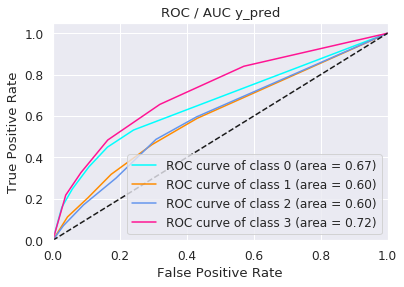

In [65]:
#Train test split
X = df1.drop(columns = ['Target']) 
y = df1['Target']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 21, test_size = .2)

#Balance data
sm = SMOTE(random_state=42, sampling_strategy= 'not majority')
X_train_array, y_train_array = sm.fit_resample(X_train, y_train)
y_train_resampled = pd.Series(y_train_array)
X_train_resampled = pd.DataFrame(X_train_array, columns = X_train.columns)

#create model
knn = KNeighborsClassifier()

#start timer
start_time = datetime.now()

#fit model
knn.fit(X_train_resampled, y_train_resampled)

#end timer
end_time = datetime.now()

#create predictions
y_pred = knn.predict(X_test)

#metrics
print('Duration: {}'.format(end_time - start_time))
print('Train Accuracy: {}'.format(knn.score(X_train, y_train)))
print('Test Accuracy: {}'.format(knn.score(X_test, y_test)))
print('Test F1: {}'.format(f1_score(y_test, y_pred, average = 'weighted')))

#set up ROC/AUC
y_score = knn.predict_proba(X_test)
n_classes = 4

y_test_bin = label_binarize(y_test, classes=[1, 2, 3, 4])

fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

#plot 
plt.figure()

colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'deeppink'])
for i, color in zip(range(0, 4, 1), colors):
    plt.plot(fpr[i], tpr[i], color=color,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC / AUC y_pred')
plt.legend(loc="lower right")
plt.show()

## SVM

In [74]:
#Train test split
X = df1.drop(columns = ['Target']) 
y = df1['Target']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 21, test_size = .2)

#Balance data
sm = SMOTE(random_state=42, sampling_strategy= 'not majority')
X_train_array, y_train_array = sm.fit_resample(X_train, y_train)
y_train_resampled = pd.Series(y_train_array)
X_train_resampled = pd.DataFrame(X_train_array, columns = X_train.columns)

#create model
svm = SVC()

#start timer
start_time = datetime.now()

#fit model
svm.fit(X_train_resampled, y_train_resampled)

#end timer
end_time = datetime.now()

#create predictions
y_pred = svm.predict(X_test)

#metrics
print('Duration: {}'.format(end_time - start_time))
print('Train Accuracy: {}'.format(svm.score(X_train, y_train)))
print('Test Accuracy: {}'.format(svm.score(X_test, y_test)))
print('Test F1: {}'.format(f1_score(y_test, y_pred, average = 'weighted')))

Duration: 0:02:58.810292
Train Accuracy: 0.9837717576233477
Test Accuracy: 0.6190476190476191
Test F1: 0.5434550190670056


## Gradient Boosting

Duration: 0:00:38.540338
Train Accuracy: 0.14199712079570737
Test Accuracy: 0.14442700156985872
Test F1: 0.14442700156985872


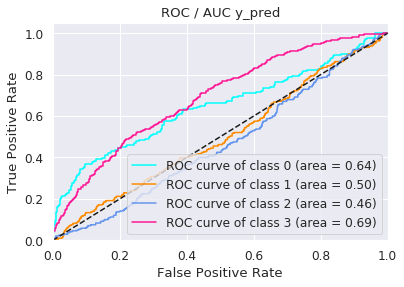

In [54]:
#scale data
scaler = StandardScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)
X_train_scaled, X_test_scaled, y_train, y_test = train_test_split(X_scaled, y, test_size = .2, random_state = 21)

#Balance data
sm = SMOTE(random_state=42, sampling_strategy= 'not majority')
X_train_array, y_train_array = sm.fit_resample(X_train_scaled, y_train)
y_train_resampled = pd.Series(y_train_array)
X_train_resampled = pd.DataFrame(X_train_array, columns = X_train.columns)

#create model
gbc = GradientBoostingClassifier()

#start timer
start_time = datetime.now()

#fit model
gbc.fit(X_train_resampled, y_train_resampled)

#end timer
end_time = datetime.now()

#create predictions
y_pred = gbc.predict(X_test)

#metrics
print('Duration: {}'.format(end_time - start_time))
print('Train Accuracy: {}'.format(gbc.score(X_train, y_train)))
print('Test Accuracy: {}'.format(gbc.score(X_test, y_test)))
print('Test F1: {}'.format(f1_score(y_test, y_pred, average = 'weighted')))

#set up ROC/AUC
y_score = gbc.predict_proba(X_test)
n_classes = 4

y_test_bin = label_binarize(y_test, classes=[1, 2, 3, 4])

fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

#plot 
plt.figure()

colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'deeppink'])
for i, color in zip(range(0, 4, 1), colors):
    plt.plot(fpr[i], tpr[i], color=color,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC / AUC y_pred')
plt.legend(loc="lower right")
plt.show()

## Ada Boost

Duration: 0:01:31.414230
Train Accuracy: 0.6823714173537495
Test Accuracy: 0.6572475143903715
Test F1: 0.6572475143903715


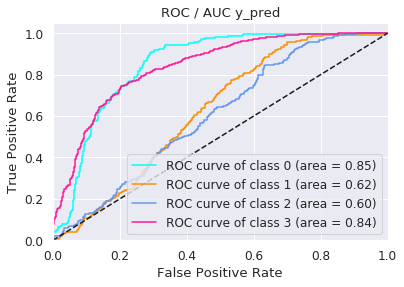

In [53]:
#Train test split
X = df1.drop(columns = ['Target']) 
y = df1['Target']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 21, test_size = .2)

#Balance data
sm = SMOTE(random_state=42, sampling_strategy= 'not majority')
X_train_array, y_train_array = sm.fit_resample(X_train, y_train)
y_train_resampled = pd.Series(y_train_array)
X_train_resampled = pd.DataFrame(X_train_array, columns = X_train.columns)

#create model
ada = AdaBoostClassifier(learning_rate = .5, n_estimators = 1000, random_state = 21)

#start timer
start_time = datetime.now()

#fit model
ada.fit(X_train_resampled, y_train_resampled)

#end timer
end_time = datetime.now()

#create predictions
y_pred = ada.predict(X_test)

#metrics
print('Duration: {}'.format(end_time - start_time))
print('Train Accuracy: {}'.format(ada.score(X_train, y_train)))
print('Test Accuracy: {}'.format(ada.score(X_test, y_test)))
print('Test F1: {}'.format(f1_score(y_test, y_pred, average = 'weighted')))

#set up ROC/AUC
y_score = ada.predict_proba(X_test)
n_classes = 4

y_test_bin = label_binarize(y_test, classes=[1, 2, 3, 4])

fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

#plot 
plt.figure()

colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'deeppink'])
for i, color in zip(range(0, 4, 1), colors):
    plt.plot(fpr[i], tpr[i], color=color,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC / AUC y_pred')
plt.legend(loc="lower right")
plt.show()

## XG Boost

#### Baseline XG Boost

Duration: 0:00:01.248353
Train Accuracy: 0.7504253369977751
Test Accuracy: 0.7305075876504448
Test F1: 0.7305075876504448


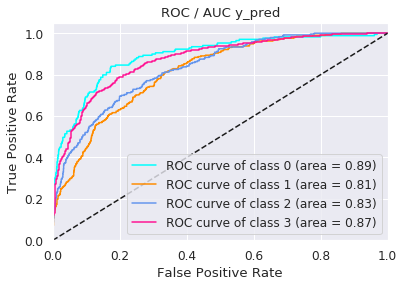

In [60]:
#Train test split
X = df1.drop(columns = ['Target']) 
y = df1['Target']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 21, test_size = .2)

#Balance data
sm = SMOTE(random_state=42, sampling_strategy= 'not majority')
X_train_array, y_train_array = sm.fit_resample(X_train, y_train)
y_train_resampled = pd.Series(y_train_array)
X_train_resampled = pd.DataFrame(X_train_array, columns = X_train.columns)

#create model
xgb = XGBClassifier(n_estimators = 100, tree_method = 'gpu_hist', gpu_id = '0')

#start timer
start_time = datetime.now()

#fit model
xgb.fit(X_train_resampled, y_train_resampled)

#end timer
end_time = datetime.now()

#make predictions
y_pred = xgb.predict(X_test)

print('Duration: {}'.format(end_time - start_time))
print('Train Accuracy: {}'.format(xgb.score(X_train, y_train)))
print('Test Accuracy: {}'.format(xgb.score(X_test, y_test)))
print('Test F1: {}'.format(f1_score(y_test, y_pred, average = 'weighted')))

#set up ROC/AUC
y_score = xgb.predict_proba(X_test)
n_classes = 4

y_test_bin = label_binarize(y_test, classes=[1, 2, 3, 4])

fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

#plot 
plt.figure()

colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'deeppink'])
for i, color in zip(range(0, 4, 1), colors):
    plt.plot(fpr[i], tpr[i], color=color,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC / AUC y_pred')
plt.legend(loc="lower right")
plt.show()

In [62]:
y_test_bin.shape

(1911, 4)

#### Grid Search XG Boost

In [56]:
#Train test split
X = df1.drop(columns = ['Target']) 
y = df1['Target']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 21, test_size = .2)

#Balance data
sm = SMOTE(random_state=42, sampling_strategy= 'not majority')
X_train_array, y_train_array = sm.fit_resample(X_train, y_train)
y_train_resampled = pd.Series(y_train_array)
X_train_resampled = pd.DataFrame(X_train_array, columns = X_train.columns)

#parameters
params = {
    'learning_rate' : [.1, .3],
    'max_depth': [3, 9],
    'n_estimators': [1000],
}

#create model
xgb = XGBClassifier(tree_method = 'gpu_hist', gpu_id = '0')
grid = GridSearchCV(xgb, params, cv = 3)

#start timer
start_time = datetime.now()

#fit model
grid.fit(X_train_resampled, y_train_resampled)

#end timer
end_time = datetime.now()

#make predictions
y_pred = grid.predict(X_test)

#determin best hyperparameters
grid.best_estimator_.learning_rate, grid.best_estimator_.max_depth, grid.best_estimator_.n_estimators

print('Duration: {}'.format(end_time - start_time))
print('Train Accuracy: {}'.format(grid.score(X_train_resampled, y_train_resampled)))
print('Test Accuracy: {}'.format(grid.score(X_test, y_test)))
print('Test F1: {}'.format(f1_score(y_test, y_pred, average = 'weighted')))

#determin best hyperparameters
grid.best_estimator_.learning_rate, grid.best_estimator_.max_depth, grid.best_estimator_.n_estimators

Duration: 0:03:17.166609
Train Accuracy: 1.0
Test Accuracy: 0.9455782312925171
Test F1: 0.9455782312925171


(0.3, 9, 1000)

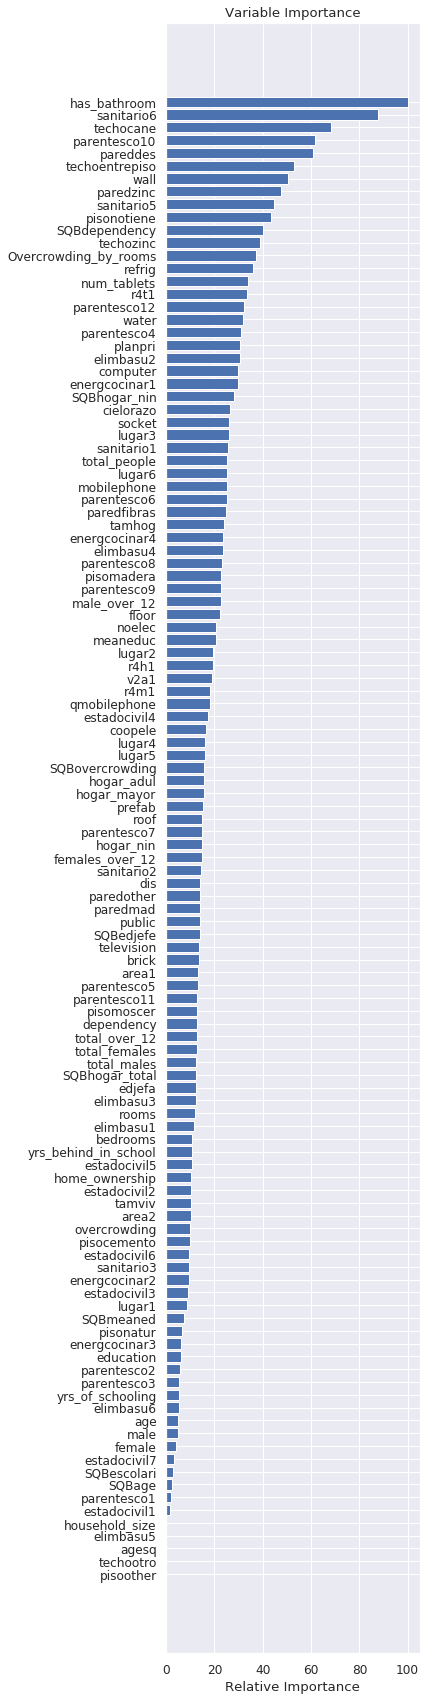

In [57]:
feature_importance = grid.best_estimator_.feature_importances_

plt.figure(figsize= (10,30))
feature_importance = 100.0 * (feature_importance / feature_importance.max()) 
sorted_idx = np.argsort(feature_importance) 
pos = np.arange(sorted_idx.shape[0]) + .5 
plt.subplot(1, 2, 2) 
plt.barh(pos, feature_importance[sorted_idx], align='center') 
plt.yticks(pos, X.columns[sorted_idx]) 
plt.xlabel('Relative Importance') 
plt.title('Variable Importance') 
plt.show()

#### Revised XG Boost with Best Hyperparameters

Duration: 0:00:19.187089
Train Accuracy: 1.0
Test Accuracy: 0.9455782312925171
Test F1: 0.9455782312925171


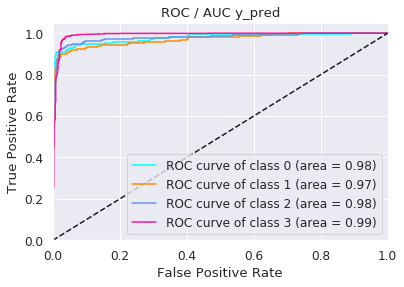

In [58]:
#Train test split
X = df1.drop(columns = ['Target']) 
y = df1['Target']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 21, test_size = .2)

#Balance data
sm = SMOTE(random_state=42, sampling_strategy= 'not majority')
X_train_array, y_train_array = sm.fit_resample(X_train, y_train)
y_train_resampled = pd.Series(y_train_array)
X_train_resampled = pd.DataFrame(X_train_array, columns = X_train.columns)

#create model
xgb = XGBClassifier(max_depth=9, learning_rate=.3, n_estimators=1000, tree_method = 'gpu_hist', gpu_id = '0')

#start timer
start_time = datetime.now()

#fit model
xgb.fit(X_train_resampled, y_train_resampled)

#end timer
end_time = datetime.now()

#make predictions
y_pred = xgb.predict(X_test)

#metrics
print('Duration: {}'.format(end_time - start_time))
print('Train Accuracy: {}'.format(xgb.score(X_train_resampled, y_train_resampled)))
print('Test Accuracy: {}'.format(xgb.score(X_test, y_test)))
print('Test F1: {}'.format(f1_score(y_test, y_pred, average = 'weighted')))

#set up ROC/AUC
y_score = xgb.predict_proba(X_test)
n_classes = 4

y_test_bin = label_binarize(y_test, classes=[1, 2, 3, 4])

fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

#plot 
plt.figure()

colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'deeppink'])
for i, color in zip(range(0, 4, 1), colors):
    plt.plot(fpr[i], tpr[i], color=color,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC / AUC y_pred')
plt.legend(loc="lower right")
plt.show()

# Catboost

Duration: 0:02:19.787293
Train Accuracy: 1.0
Test Accuracy: 0.9225536368393511
Test F1: 0.9225536368393511


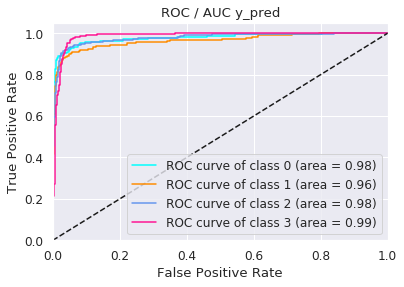

In [59]:
#Train test split
X = df1.drop(columns = ['Target']) 
y = df1['Target']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 21, test_size = .2)

#Balance data
sm = SMOTE(random_state=42, sampling_strategy= 'not majority')
X_train_array, y_train_array = sm.fit_resample(X_train, y_train)

#create model
cbc = CatBoostClassifier(random_state = 21, task_type = 'GPU', silent = True, iterations = 10000)

#start timer
start_time = datetime.now()

#fit model
cbc.fit(X_train_array, y_train_array)

#end timer
end_time = datetime.now()

#make predictions
y_pred = cbc.predict(X_test)

print('Duration: {}'.format(end_time - start_time))
print('Train Accuracy: {}'.format(cbc.score(X_train, y_train)))
print('Test Accuracy: {}'.format(cbc.score(X_test, y_test)))
print('Test F1: {}'.format(f1_score(y_test, y_pred, average = 'weighted')))

#set up ROC/AUC
y_score = cbc.predict_proba(X_test)
n_classes = 4

y_test_bin = label_binarize(y_test, classes=[1, 2, 3, 4])

fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

#plot 
plt.figure()

colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'deeppink'])
for i, color in zip(range(0, 4, 1), colors):
    plt.plot(fpr[i], tpr[i], color=color,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC / AUC y_pred')
plt.legend(loc="lower right")
plt.show()

# Conclusion

- Most Important Features

- Best Performing Model

- Overall Metrics

- Improvements to Model